In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, cv, Pool
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, make_scorer, mean_absolute_percentage_error
from sklearn.feature_selection import r_regression
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns",None)

In [2]:
df = pd.read_json('DATASET_FINAL.json')

In [3]:
# Groupement des acteurs 1, 2, 3 , scénaristes, réalisateurs, et distributeurs qui font plus de 500k entrées 
# + ajout d'un groupe "mid" entre 250k et 500k

# Acteur 1
df_actor_1 = df.groupby('actor_1')['weekly_entrances'].mean().reset_index()
df_actor_1_mid = df_actor_1[(df_actor_1['weekly_entrances'] < 500001) & (df_actor_1['weekly_entrances'] > 250000)].sort_values(by='weekly_entrances', ascending=False)
df_actor_1 = df_actor_1[df_actor_1['weekly_entrances'] > 500000].sort_values(by='weekly_entrances', ascending=False)

# Acteur 2
df_actor_2 = df.groupby('actor_2')['weekly_entrances'].mean().reset_index()
df_actor_2_mid = df_actor_2[(df_actor_2['weekly_entrances'] < 500001) & (df_actor_2['weekly_entrances'] > 250000)].sort_values(by='weekly_entrances', ascending=False)
df_actor_2 = df_actor_2[df_actor_2['weekly_entrances'] > 500000].sort_values(by='weekly_entrances', ascending=False)

# Acteur 3
df_actor_3 = df.groupby('actor_3')['weekly_entrances'].mean().reset_index()
df_actor_3_mid = df_actor_3[(df_actor_3['weekly_entrances'] < 500001) & (df_actor_3['weekly_entrances'] > 250000)].sort_values(by='weekly_entrances', ascending=False)
df_actor_3 = df_actor_3[df_actor_3['weekly_entrances'] > 500000].sort_values(by='weekly_entrances', ascending=False)

# Réalisateurs
df_directors = df.groupby('directors')['weekly_entrances'].mean().reset_index()
df_directors_mid = df_directors[(df_directors['weekly_entrances'] < 500001) & (df_directors['weekly_entrances'] > 250000)].sort_values(by='weekly_entrances', ascending=False)
df_directors = df_directors[df_directors['weekly_entrances'] > 500000].sort_values(by='weekly_entrances', ascending=False)

# Scénaristes
df_writer = df.groupby('writer')['weekly_entrances'].mean().reset_index()
df_writer_mid = df_writer[(df_writer['weekly_entrances'] < 500001) & (df_writer['weekly_entrances'] > 250000)].sort_values(by='weekly_entrances', ascending=False)
df_writer = df_writer[df_writer['weekly_entrances'] > 500000].sort_values(by='weekly_entrances', ascending=False)

# Distributeurs
df_distribution = df.groupby('distribution')['weekly_entrances'].mean().reset_index()
df_distribution_mid = df_distribution[(df_distribution['weekly_entrances'] < 500001) & (df_distribution['weekly_entrances'] > 250000)].sort_values(by='weekly_entrances', ascending=False)
df_distribution = df_distribution[df_distribution['weekly_entrances'] > 500000].sort_values(by='weekly_entrances', ascending=False)

# Création des colonnes "top" et "top_mid" pour les différents groupes

df['top_actor_1'] = df['actor_1'].apply(lambda x: 1 if x in df_actor_1['actor_1'].to_list() else 0)
df['top_actor_1_mid'] = df['actor_1'].apply(lambda x: 1 if x in df_actor_1_mid['actor_1'].to_list() else 0)

df['top_actor_2'] = df['actor_2'].apply(lambda x: 1 if x in df_actor_2['actor_2'].to_list() else 0)
df['top_actor_2_mid'] = df['actor_2'].apply(lambda x: 1 if x in df_actor_2_mid['actor_2'].to_list() else 0)

df['top_actor_3'] = df['actor_3'].apply(lambda x: 1 if x in df_actor_3['actor_3'].to_list() else 0)
df['top_actor_3_mid'] = df['actor_3'].apply(lambda x: 1 if x in df_actor_3_mid['actor_3'].to_list() else 0)

df['top_director'] = df['directors'].apply(lambda x: 1 if x in df_directors['directors'].to_list() else 0)
df['top_director_mid'] = df['directors'].apply(lambda x: 1 if x in df_directors_mid['directors'].to_list() else 0)

df['top_writer'] = df['writer'].apply(lambda x: 1 if x in df_writer['writer'].to_list() else 0)
df['top_writer_mid'] = df['writer'].apply(lambda x: 1 if x in df_writer_mid['writer'].to_list() else 0)

df['top_distribution'] = df['distribution'].apply(lambda x: 1 if x in df_distribution['distribution'].to_list() else 0)
df['top_distribution_mid'] = df['distribution'].apply(lambda x: 1 if x in df_distribution_mid['distribution'].to_list() else 0)



In [4]:
# Définition des bornes de classification (en dollars)
bins = [0,5_000_000, 30_000_000, 100_000_000, float('inf')]

# Noms des catégories correspondantes
labels = [
    # "Ultra low budget",
    "Low budget",
    "Mid budget",
    "High budget",
    "Blockbuster / AAA"
]

# Création de la nouvelle colonne "budget_category"
df['budget_category'] = pd.cut(df['budget'], bins=bins, labels=labels, right=False)

# Affichage du résultat
df.head()

df['top_pays'] = df.country.apply(lambda x : 1 if x in (['France','Etats-Unis','Grande-Bretagne']) else 0)

df.released_date=pd.to_datetime(df.released_date)


df["summer"] = df["released_date"].apply(lambda x: 1 if ((x.month == 6 and x.day >= 21) or x.month in [7, 8] or (x.month == 9 and x.day < 22)) else 0)
df["automn"] = df["released_date"].apply(lambda x: 1 if ((x.month == 9 and x.day >= 22) or x.month in [10, 11] or (x.month == 12 and x.day < 21)) else 0)
df["winter"] = df["released_date"].apply(lambda x: 1 if ((x.month == 12 and x.day >= 21) or x.month in [1, 2] or (x.month == 3 and x.day < 20)) else 0)
df["spring"] = df["released_date"].apply(lambda x: 1 if ((x.month == 3 and x.day >= 21) or x.month in [4, 5] or (x.month == 6 and x.day < 21)) else 0)

df["is_covid"] = df["released_date"].apply(lambda x: 1 if (
    (x >= pd.to_datetime("2020-03-17") and x <= pd.to_datetime("2020-05-11")) or
    (x >= pd.to_datetime("2020-10-30") and x <= pd.to_datetime("2020-12-15")) or
    (x >= pd.to_datetime("2021-04-03") and x <= pd.to_datetime("2021-05-03"))
) else 0)

df["post_streaming"] = df["released_date"].apply(lambda x: 1 if x >= pd.to_datetime("2014-09-15") else 0)

df["summer_holidays"] = df["released_date"].apply(lambda x: 1 if x.month >= 7 or (x.month <= 9 and x.day < 10) else 0)

df["christmas_period"] = df["released_date"].apply(lambda x: 1 if (x.month == 12 and x.day >= 20) or (x.month == 1 and x.day <= 5) else 0)

df["is_award_season"] = df["released_date"].apply(lambda x: 1 if (x.month == 2 or (x.month == 3 and x.day <= 10)) else 0)


In [5]:
features_of_interest = [
    "actor_1",
    "actor_2",
    'actor_3',
    "directors",
     "writer",
    "distribution",
    "fr_title",
    'released_year',
    "country",
    "budget",
    'category',
    'classification',
    'duration_minutes', 
    "top_actor_1",
    "top_actor_2",
    "top_actor_3",
    "top_director",
    'top_writer',
    'top_distribution',
    "top_actor_1_mid",
    "top_actor_2_mid",
    "top_actor_3_mid",
    "top_director_mid",
    'top_writer_mid',
    'top_distribution_mid',
    'budget_category',
    'top_pays',
    'summer',
    'automn',
    'winter',
    'spring',
    'post_streaming',
    'summer_holidays',
    'christmas_period',
    'is_award_season',
]


numerical_column = [
    "budget",
    'released_year',
    "duration_minutes",
    "top_actor_1",
    "top_actor_2",
    "top_actor_3",
    "top_director",
    'top_writer',
    "top_actor_1_mid",
    "top_actor_2_mid",
    "top_actor_3_mid",
    "top_director_mid",
    'top_writer_mid',
    'top_distribution_mid',
    'top_distribution',
    'top_pays',
        'summer',
    'automn',
    'winter',
    'spring',
    'post_streaming',
    'summer_holidays',
    'christmas_period',
    'is_award_season',
    "weekly_entrances"

]



categorical_column = [
        "actor_1",
        "actor_2",
        "actor_3",
        "directors",
        "writer",
        "distribution",
    "fr_title",
    "country",
    'category',
    'classification',
    'budget_category',
    "weekly_entrances"

]

#
target_name = "weekly_entrances"
data, target, numerical_data,categorical_data = (
    df[features_of_interest],
    df[target_name],
    df[numerical_column],
    df[categorical_column]
)

In [ ]:
from scipy.stats import f_oneway
# Exemple de dataframe df_2_anova
df_2_anova = categorical_data.copy()



# Boucle sur les colonnes discrètes
for column in df_2_anova.columns:
    if column != 'weekly_entrances':  # On ne veut pas tester 'weekly_entrances' avec lui-même
        # Créer les groupes selon les valeurs de la colonne discrète
        groups = [df_2_anova[df_2_anova[column] == category]['weekly_entrances']
                  for category in df_2_anova[column].dropna().unique()]
        
        # Appliquer le test ANOVA
        stat_anova, p_value = f_oneway(*groups)
        
#         # # Si l'ANOVA est significative (p-value < 0.05), on applique Tukey HSD
#         # if p_value < 0.05:
#         #     # Appliquer le test post-hoc Tukey
#         #     tukey_result = pairwise_tukeyhsd(df_2_anova['weekly_entrances'], df_2_anova[column])
#         #     print(f'Post-hoc Tukey HSD pour {column}:\n', tukey_result.summary())
        
        # Afficher les résultats de l'ANOVA
        print(f'Le résultat pour {column}')
        print("Statistique F:", stat_anova)
        print("P-value:", p_value)
        print('')
        print('================================================================================')


Le résultat pour actor_1
Statistique F: 1.0149291291276725
P-value: 0.33001349079003534

Le résultat pour actor_2
Statistique F: 0.9320044850622818
P-value: 0.9829834147819636

Le résultat pour actor_3
Statistique F: 0.6781887611258354
P-value: 0.9999999999999999

Le résultat pour directors
Statistique F: 1.5050970011166196
P-value: 5.003036662965276e-35

Le résultat pour writer
Statistique F: 1.4075260181823717
P-value: 8.499730665818995e-24

Le résultat pour distribution
Statistique F: 1.8537591589219735
P-value: 2.0056444949755333e-47

Le résultat pour fr_title
Statistique F: 0.41652693718026995
P-value: 0.9812119563987682

Le résultat pour country
Statistique F: 8.190931457293624
P-value: 1.9089757537287267e-78

Le résultat pour category
Statistique F: 80.04295805884722
P-value: 5.5e-321

Le résultat pour classification
Statistique F: 44.530970788712395
P-value: 8.94625648115363e-54

Le résultat pour budget_category
Statistique F: 942.4826138169309
P-value: 0.0



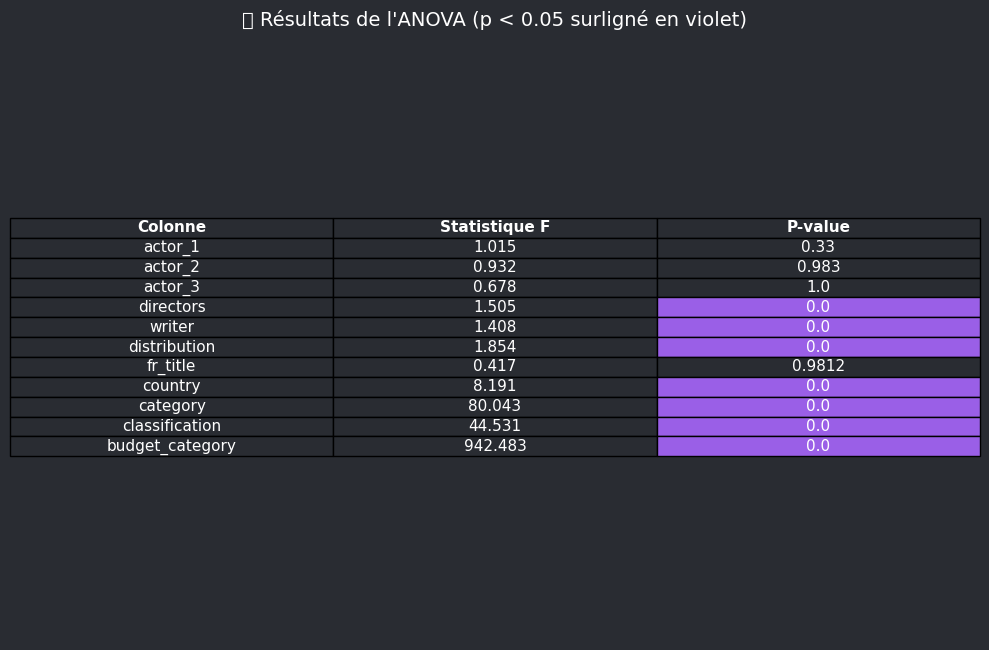

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import f_oneway

# Exemple de dataframe df_2_anova
df_2_anova = categorical_data.copy()

# Liste pour stocker les résultats
results = []

# Boucle sur les colonnes discrètes
for column in df_2_anova.columns:
    if column != 'weekly_entrances':
        groups = [df_2_anova[df_2_anova[column] == category]['weekly_entrances']
                  for category in df_2_anova[column].dropna().unique()]
        
        stat_anova, p_value = f_oneway(*groups)
        results.append([column, round(stat_anova, 3), round(p_value, 4)])

# Créer DataFrame
results_df = pd.DataFrame(results, columns=['Colonne', 'Statistique F', 'P-value'])

# 🎨 Couleurs personnalisées
background_color = '#292c32'  # Fond noir doux
highlight_color = '#9a5fe7'   # Violet cinéma pour p < 0.05
text_color = 'white'

# Création du tableau matplotlib
fig, ax = plt.subplots(figsize=(10, len(results_df) * 0.6))
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)
ax.axis('off')
ax.axis('tight')

# Création du tableau
table = ax.table(cellText=results_df.values,
                 colLabels=results_df.columns,
                 loc='center',
                 cellLoc='center',
                 colLoc='center')

# Appliquer les styles
table.auto_set_font_size(False)
table.set_fontsize(11)

# Fond noir pour toutes les cellules + texte blanc
for i in range(len(results_df)):
    for j in range(3):
        cell = table[(i+1, j)]
        cell.set_facecolor(background_color)
        cell.set_text_props(color=text_color)
        
    # Surlignage violet si p < 0.05
    if results_df.loc[i, 'P-value'] < 0.05:
        table[(i+1, 2)].set_facecolor(highlight_color)

# En-têtes en fond noir et texte blanc
for j in range(3):
    header = table[(0, j)]
    header.set_facecolor(background_color)
    header.set_text_props(color=text_color, weight='bold')

# Titre
plt.title("Résultats de l'ANOVA (p < 0.05 surligné en violet)", fontsize=14, color=text_color)

plt.tight_layout()
plt.show()



top_writer              0.657215
top_director            0.605329
budget                  0.551593
top_actor_3             0.548011
top_actor_2             0.516664
top_actor_1             0.475137
top_distribution        0.302629
top_distribution_mid    0.278943
duration_minutes        0.233714
top_actor_2_mid         0.206527
top_actor_1_mid         0.200494
top_actor_3_mid         0.196029
top_pays                0.183810
top_director_mid        0.182820
top_writer_mid          0.161180
released_year          -0.078528
post_streaming         -0.062036
is_award_season         0.046447
automn                  0.026380
christmas_period       -0.025254
summer                 -0.021834
summer_holidays        -0.010499
spring                 -0.007690
winter                  0.002949
Name: weekly_entrances, dtype: float64


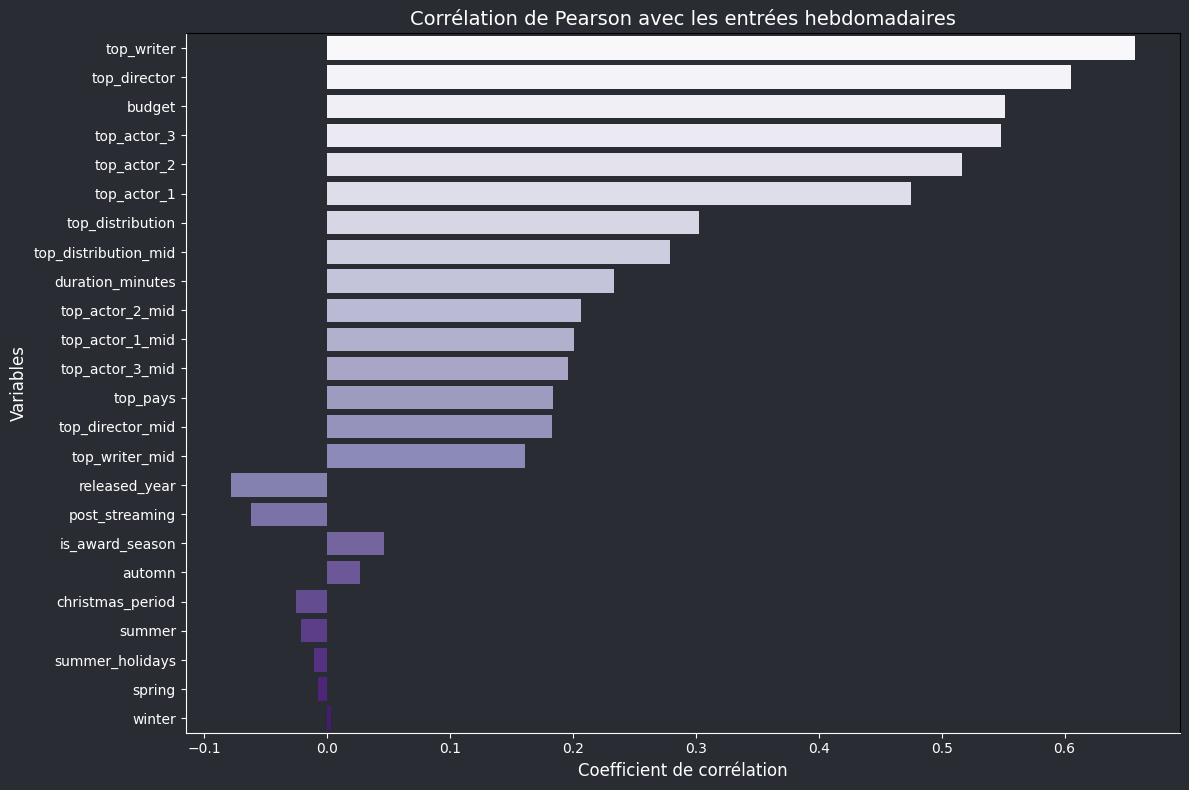

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_df_pearson = numerical_data.corr()
# Calcul des corrélations avec la cible uniquement
target_corr = corr_df_pearson['weekly_entrances'].drop('weekly_entrances')
target_corr = target_corr.sort_values(key=abs, ascending=False)
print (target_corr)
# Créer la figure avec fond personnalisé
fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor('#292c32')  # Fond du canvas
ax.set_facecolor('#292c32')         # Fond du graphique

# Palette violet foncé → clair
purple_palette = sns.color_palette("Purples", len(target_corr))

# Barplot avec la palette violette
sns.barplot(
    x=target_corr.values,
    y=target_corr.index,
    palette=purple_palette,
    ax=ax
)

# Titres et étiquettes en blanc
ax.set_title("Corrélation de Pearson avec les entrées hebdomadaires", color='white', fontsize=14)
ax.set_xlabel("Coefficient de corrélation", color='white', fontsize=12)
ax.set_ylabel("Variables", color='white', fontsize=12)

# Ticks et axes en blanc
ax.tick_params(colors='white')
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')

plt.tight_layout()
plt.show()


In [11]:
df.columns

Index(['fr_title', 'released_year', 'directors', 'writer', 'distribution',
       'country', 'budget', 'category', 'released_date', 'classification',
       'duration', 'weekly_entrances', 'duration_minutes', 'actor_1',
       'actor_2', 'actor_3', 'top_actor_1', 'top_actor_1_mid', 'top_actor_2',
       'top_actor_2_mid', 'top_actor_3', 'top_actor_3_mid', 'top_director',
       'top_director_mid', 'top_writer', 'top_writer_mid', 'top_distribution',
       'top_distribution_mid', 'budget_category', 'top_pays', 'summer',
       'automn', 'winter', 'spring', 'is_covid', 'post_streaming',
       'summer_holidays', 'christmas_period', 'is_award_season'],
      dtype='object')

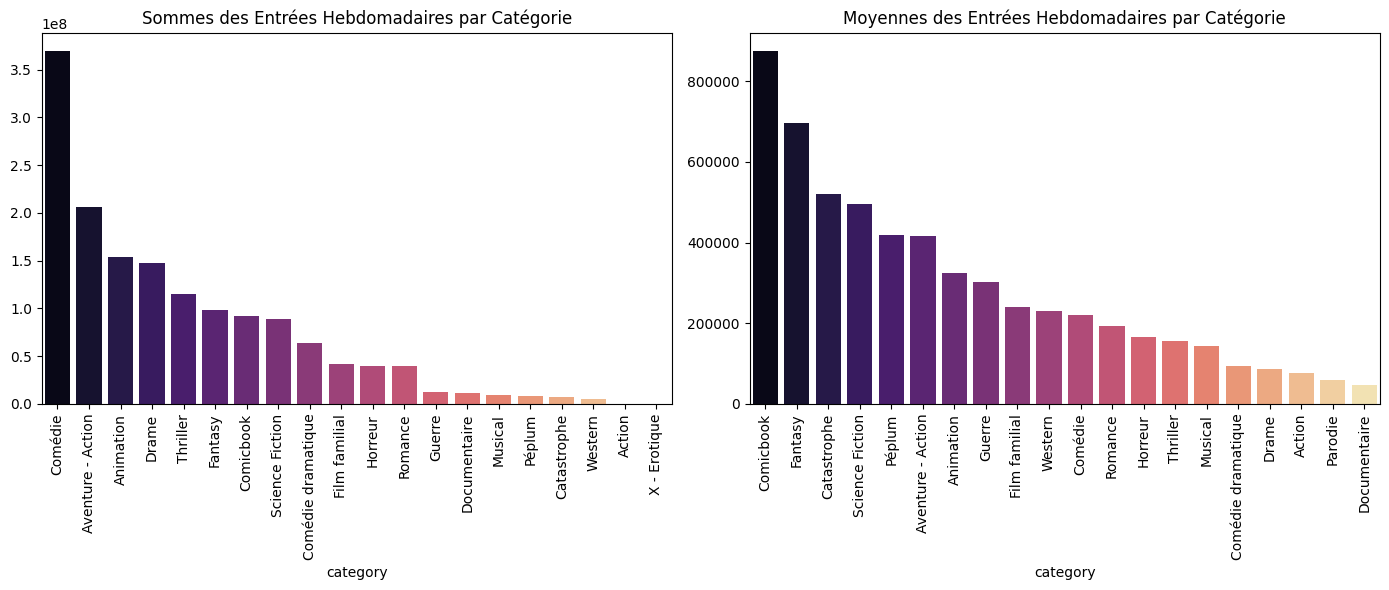

In [14]:
df_we_sum = df.groupby('category')['weekly_entrances'].sum().sort_values(ascending=False).head(20)

df_we_mean = df.groupby('category')['weekly_entrances'].mean().sort_values(ascending=False).head(20)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x=df_we_sum.index, y=df_we_sum.values, palette='magma', ax=axes[0])
axes[0].set_title('Sommes des Entrées Hebdomadaires par Catégorie')
axes[0].set_xticklabels(df_we_sum.index, rotation=90)


sns.barplot(x=df_we_mean.index, y=df_we_mean.values, palette='magma', ax=axes[1])
axes[1].set_title('Moyennes des Entrées Hebdomadaires par Catégorie')
axes[1].set_xticklabels(df_we_mean.index, rotation=90)
plt.tight_layout()
plt.show()

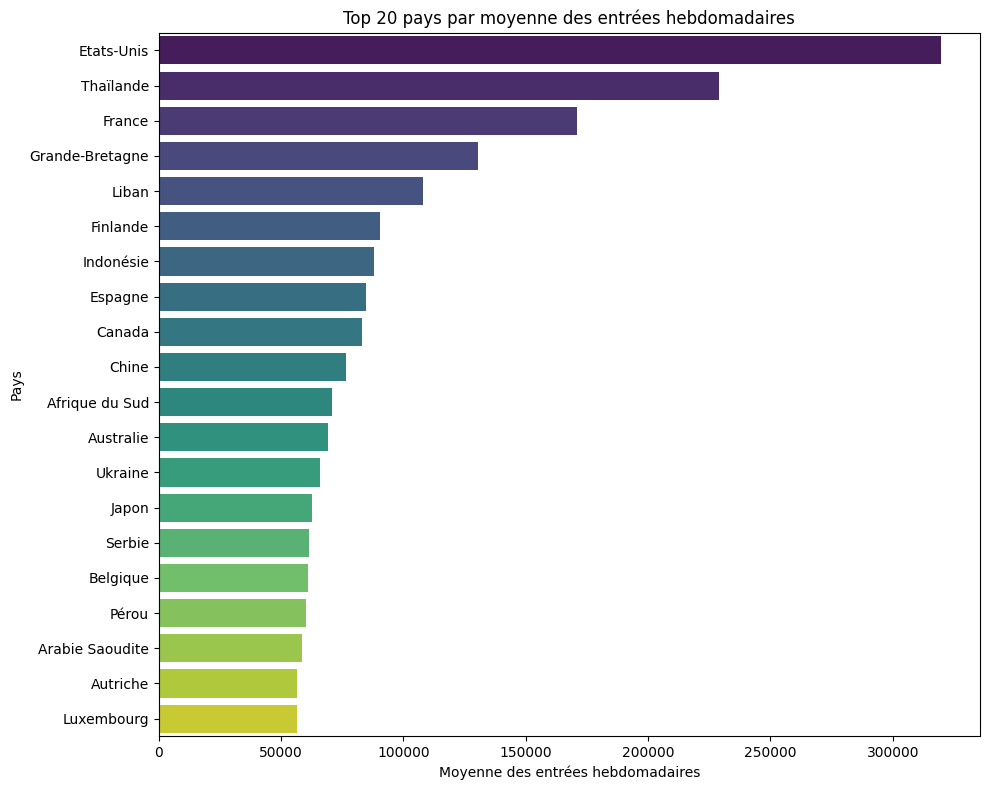

In [16]:


df_we_mean = df.groupby('country')['weekly_entrances'].mean().sort_values(ascending=False)

# On prend les 20 pays avec les meilleures moyennes
top_n = 20
df_top_mean = df_we_mean.head(top_n)

# Tracer un bar chart horizontal
plt.figure(figsize=(10, 8))
sns.barplot(x=df_top_mean.values, y=df_top_mean.index, palette="viridis")
plt.title(f'Top {top_n} pays par moyenne des entrées hebdomadaires')
plt.xlabel('Moyenne des entrées hebdomadaires')
plt.ylabel('Pays')
plt.tight_layout()
plt.show()
plt.show()

### La Thailande a eu que deux films au boxoffice français la moyenne est fortement influencée par le succès de Ong bak

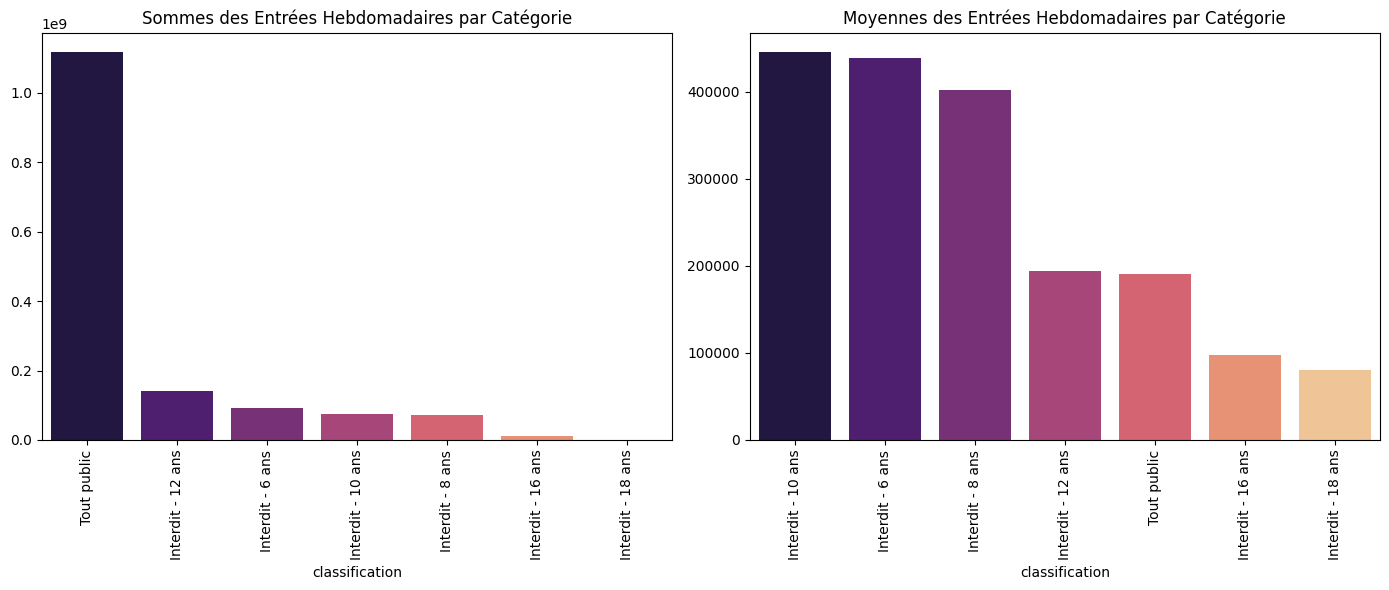

In [17]:
df_we_classification_sum = df.groupby('classification')['weekly_entrances'].sum().sort_values(ascending=False)

df_we_classification_mean = df.groupby('classification')['weekly_entrances'].mean().sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x=df_we_classification_sum.index, y=df_we_classification_sum.values, palette='magma', ax=axes[0])
axes[0].set_title('Sommes des Entrées Hebdomadaires par Catégorie')
axes[0].set_xticklabels(df_we_classification_sum.index, rotation=90)


sns.barplot(x=df_we_classification_mean.index, y=df_we_classification_mean.values, palette='magma', ax=axes[1])
axes[1].set_title('Moyennes des Entrées Hebdomadaires par Catégorie')
axes[1].set_xticklabels(df_we_classification_mean.index, rotation=90)
plt.tight_layout()
plt.show()

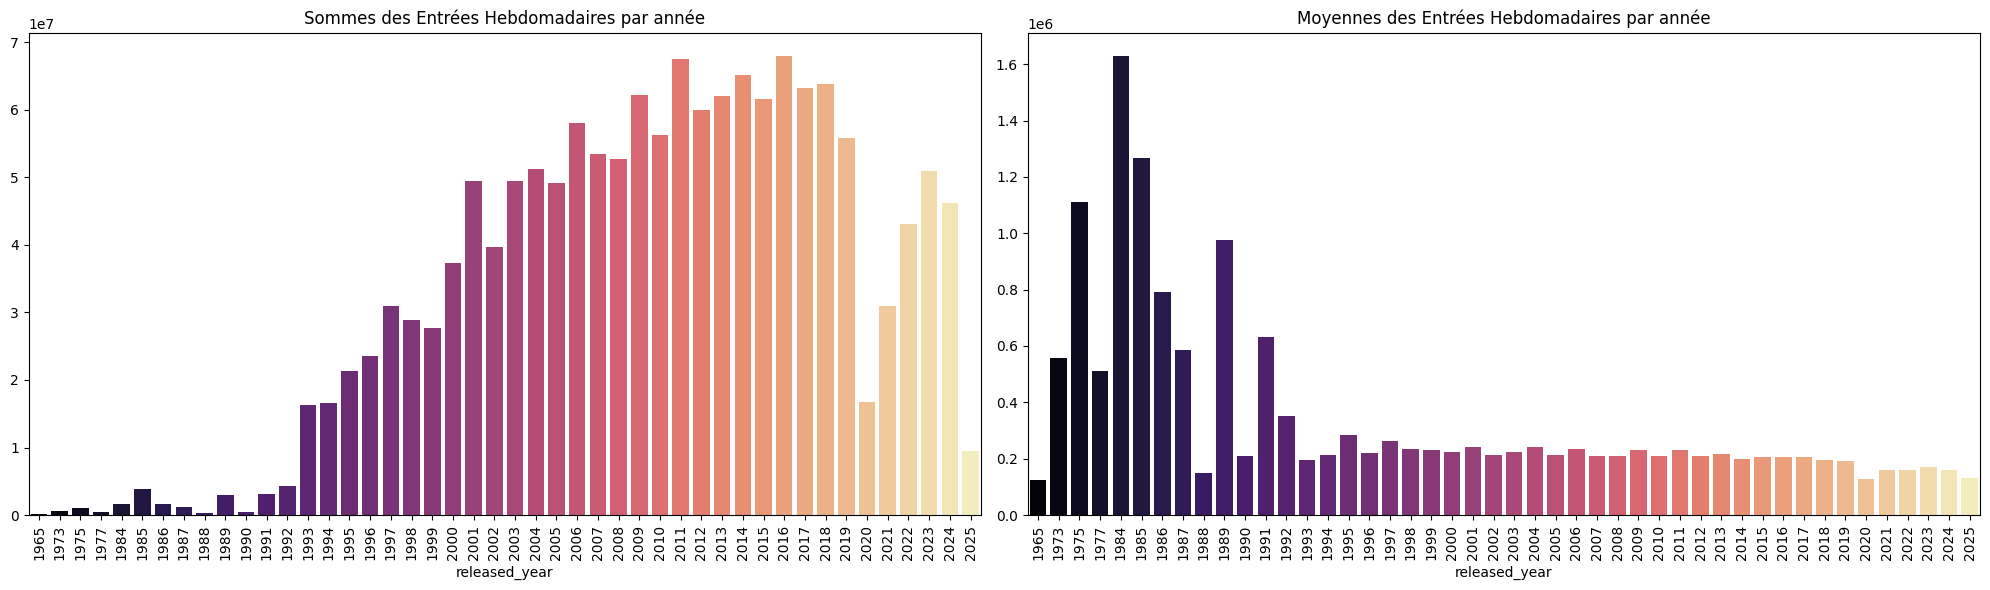

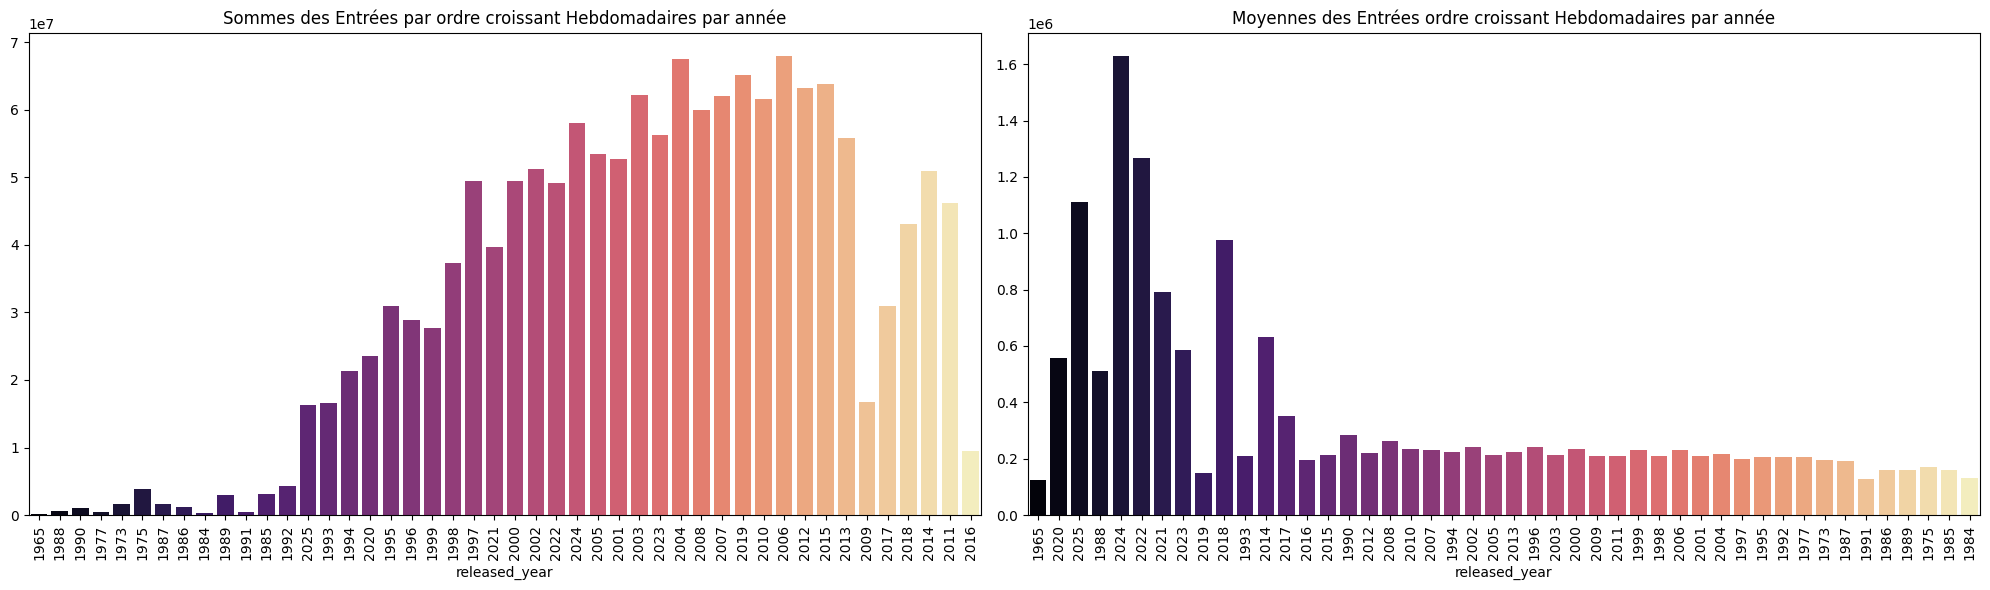

In [22]:


df_we_years_sum = df.groupby('released_year')['weekly_entrances'].sum()
df_we_years_mean = df.groupby('released_year')['weekly_entrances'].mean()

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

sns.barplot(x=df_we_years_sum.index, y=df_we_years_sum.values, palette='magma', ax=axes[0])
axes[0].set_title('Sommes des Entrées Hebdomadaires par année')
axes[0].set_xticklabels(df_we_years_sum.index, rotation=90)


sns.barplot(x=df_we_years_mean.index, y=df_we_years_mean.values, palette='magma', ax=axes[1])
axes[1].set_title('Moyennes des Entrées Hebdomadaires par année')
axes[1].set_xticklabels(df_we_years_mean.index, rotation=90)
plt.tight_layout()
plt.show()

df_we_years_sum_ORDER = df.groupby('released_year')['weekly_entrances'].sum().sort_values()
df_we_years_mean_ORDER = df.groupby('released_year')['weekly_entrances'].mean().sort_values()

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

sns.barplot(x=df_we_years_sum_ORDER.index, y=df_we_years_sum_ORDER.values, palette='magma', ax=axes[0])
axes[0].set_title('Sommes des Entrées par ordre croissant Hebdomadaires par année')
axes[0].set_xticklabels(df_we_years_sum_ORDER.index, rotation=90)


print('='*550)

sns.barplot(x=df_we_years_mean_ORDER.index, y=df_we_years_mean_ORDER.values, palette='magma', ax=axes[1])
axes[1].set_title('Moyennes des Entrées ordre croissant Hebdomadaires par année')
axes[1].set_xticklabels(df_we_years_mean_ORDER.index, rotation=90)
plt.tight_layout()
plt.show()



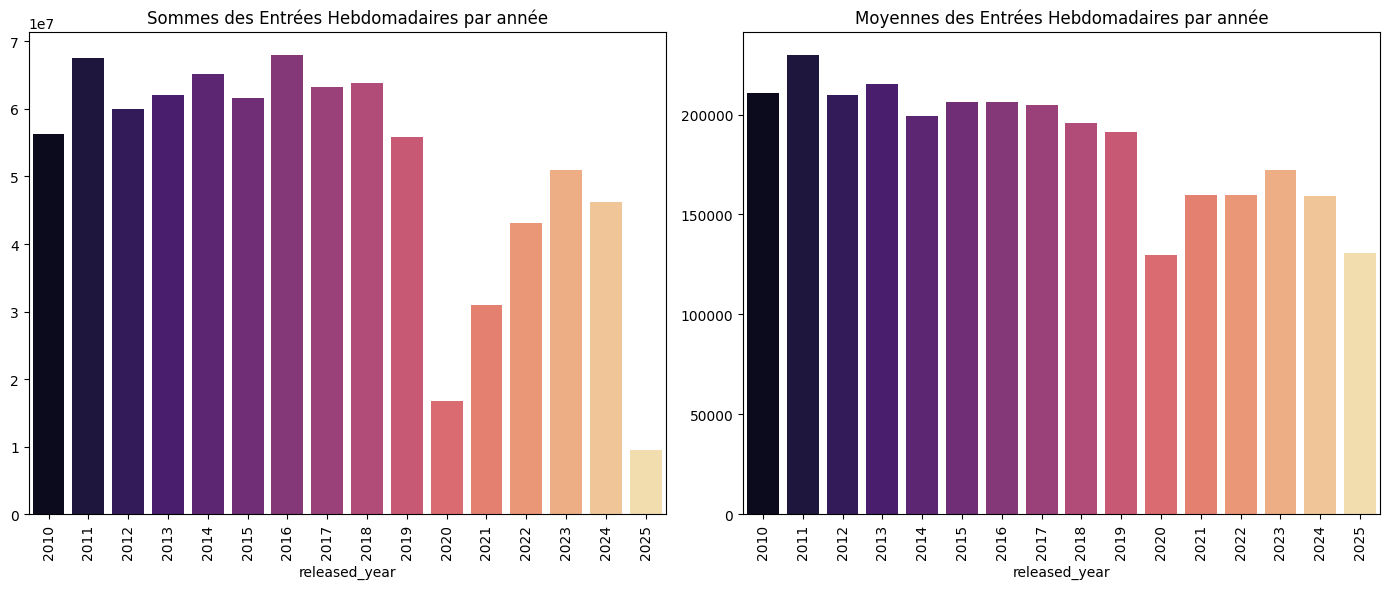

In [27]:
#AFFLUENCE PAR ANNEE À PARTIR DE 2010

df_year_2010 = df[['released_year','weekly_entrances']][pd.to_numeric(df['released_year']) > 2009]
# df_year_2010

df_we_years_sum = df_year_2010.groupby('released_year')['weekly_entrances'].sum()
df_we_years_mean = df_year_2010.groupby('released_year')['weekly_entrances'].mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x=df_we_years_sum.index, y=df_we_years_sum.values, palette='magma', ax=axes[0])
axes[0].set_title('Sommes des Entrées Hebdomadaires par année')
axes[0].set_xticklabels(df_we_years_sum.index, rotation=90)


sns.barplot(x=df_we_years_mean.index, y=df_we_years_mean.values, palette='magma', ax=axes[1])
axes[1].set_title('Moyennes des Entrées Hebdomadaires par année')
axes[1].set_xticklabels(df_we_years_mean.index, rotation=90)
plt.tight_layout()
plt.show()



In [29]:
df.columns

Index(['fr_title', 'released_year', 'directors', 'writer', 'distribution',
       'country', 'budget', 'category', 'released_date', 'classification',
       'duration', 'weekly_entrances', 'duration_minutes', 'actor_1',
       'actor_2', 'actor_3', 'top_actor_1', 'top_actor_1_mid', 'top_actor_2',
       'top_actor_2_mid', 'top_actor_3', 'top_actor_3_mid', 'top_director',
       'top_director_mid', 'top_writer', 'top_writer_mid', 'top_distribution',
       'top_distribution_mid', 'budget_category', 'top_pays', 'summer',
       'automn', 'winter', 'spring', 'is_covid', 'post_streaming',
       'summer_holidays', 'christmas_period', 'is_award_season'],
      dtype='object')

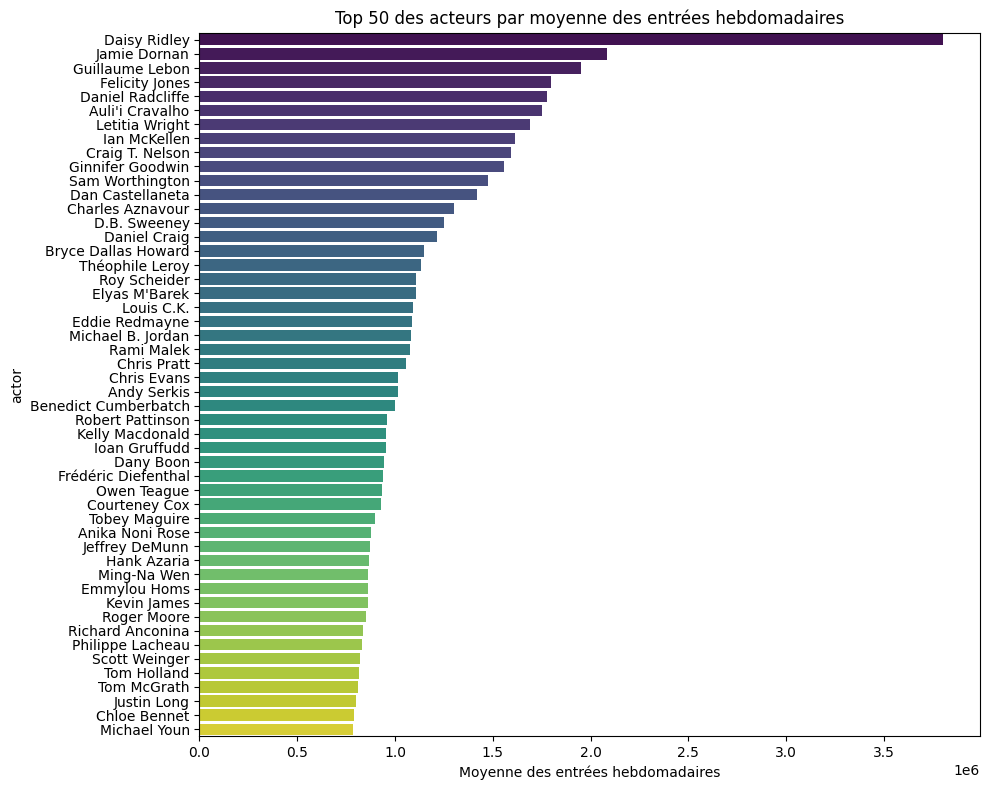

In [30]:
# On prend les 20 pays avec les meilleures moyennes
top_n = 50
df_top_actor = df.groupby('actor_1')['weekly_entrances'].mean().sort_values(ascending=False)

df_top_actor = df_top_actor.head(top_n)


# Tracer un bar chart horizontal
plt.figure(figsize=(10, 8))
sns.barplot(x=df_top_actor.values, y=df_top_actor.index, palette="viridis")
plt.title(f'Top {top_n} des acteurs par moyenne des entrées hebdomadaires')
plt.xlabel('Moyenne des entrées hebdomadaires')
plt.ylabel('actor')
plt.tight_layout()
plt.show()

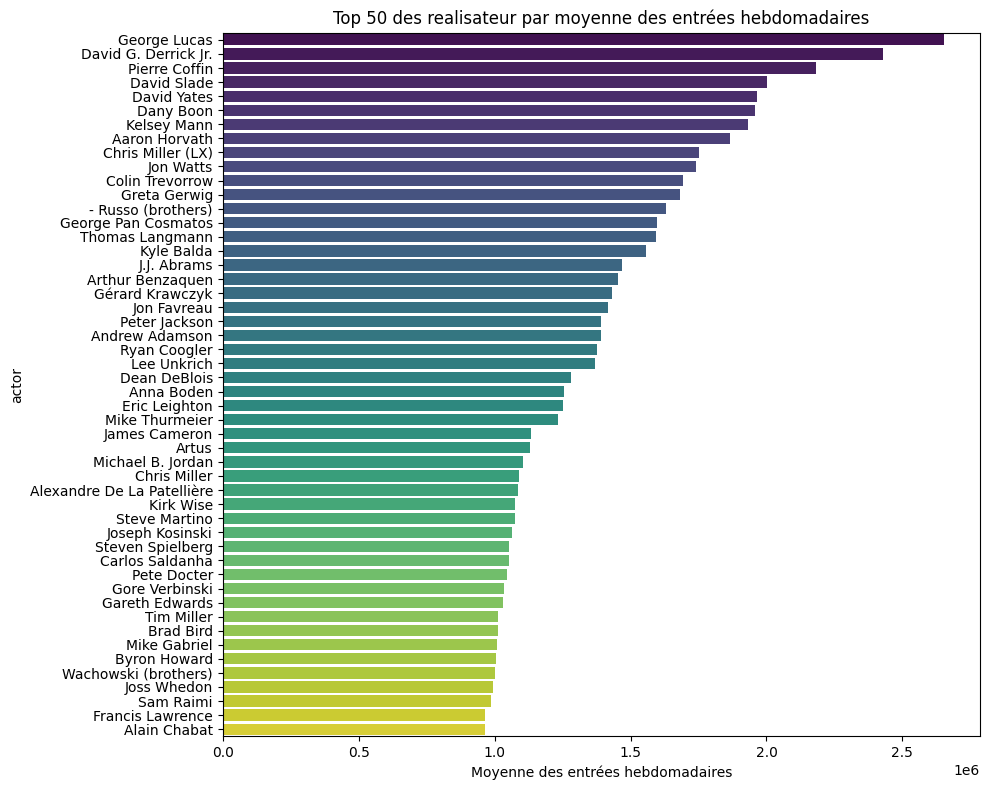

In [33]:
# On prend les 20 pays avec les meilleures moyennes
top_n = 50
df_top_actor = df.groupby('directors')['weekly_entrances'].mean().sort_values(ascending=False)

df_top_actor = df_top_actor.head(top_n)


# Tracer un bar chart horizontal
plt.figure(figsize=(10, 8))
sns.barplot(x=df_top_actor.values, y=df_top_actor.index, palette="viridis")
plt.title(f'Top {top_n} des realisateur par moyenne des entrées hebdomadaires')
plt.xlabel('Moyenne des entrées hebdomadaires')
plt.ylabel('actor')
plt.tight_layout()
plt.show()

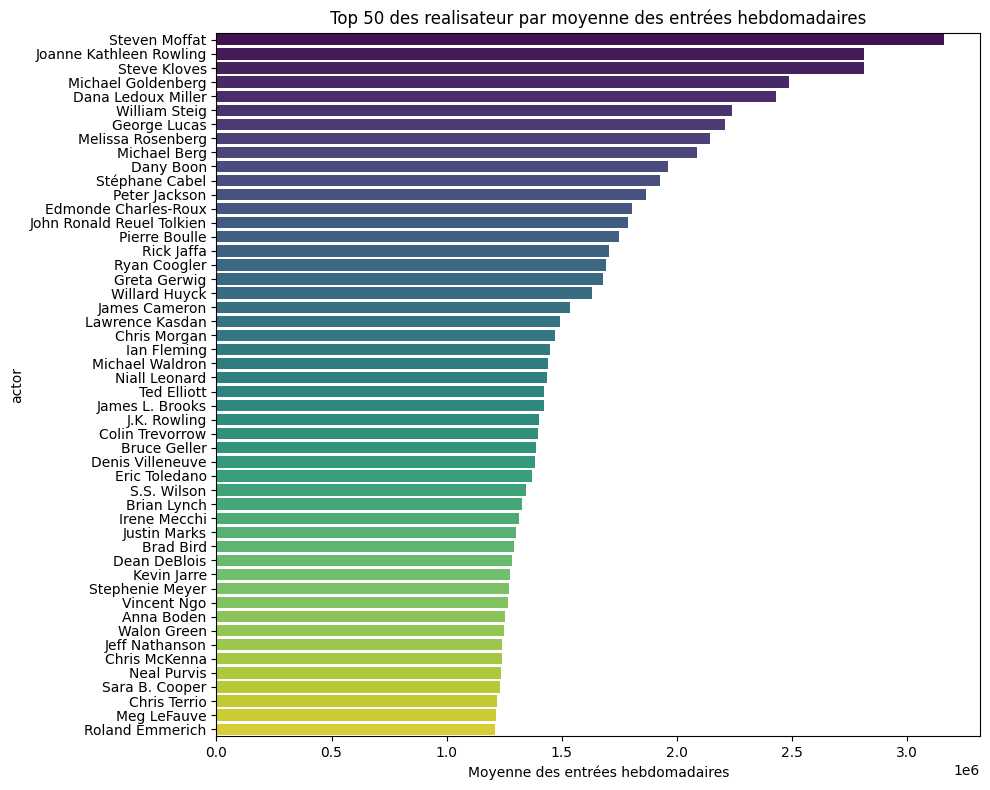

In [34]:
# On prend les 20 pays avec les meilleures moyennes
top_n = 50
df_top_actor = df.groupby('writer')['weekly_entrances'].mean().sort_values(ascending=False)

df_top_actor = df_top_actor.head(top_n)


# Tracer un bar chart horizontal
plt.figure(figsize=(10, 8))
sns.barplot(x=df_top_actor.values, y=df_top_actor.index, palette="viridis")
plt.title(f'Top {top_n} des realisateur par moyenne des entrées hebdomadaires')
plt.xlabel('Moyenne des entrées hebdomadaires')
plt.ylabel('actor')
plt.tight_layout()
plt.show()

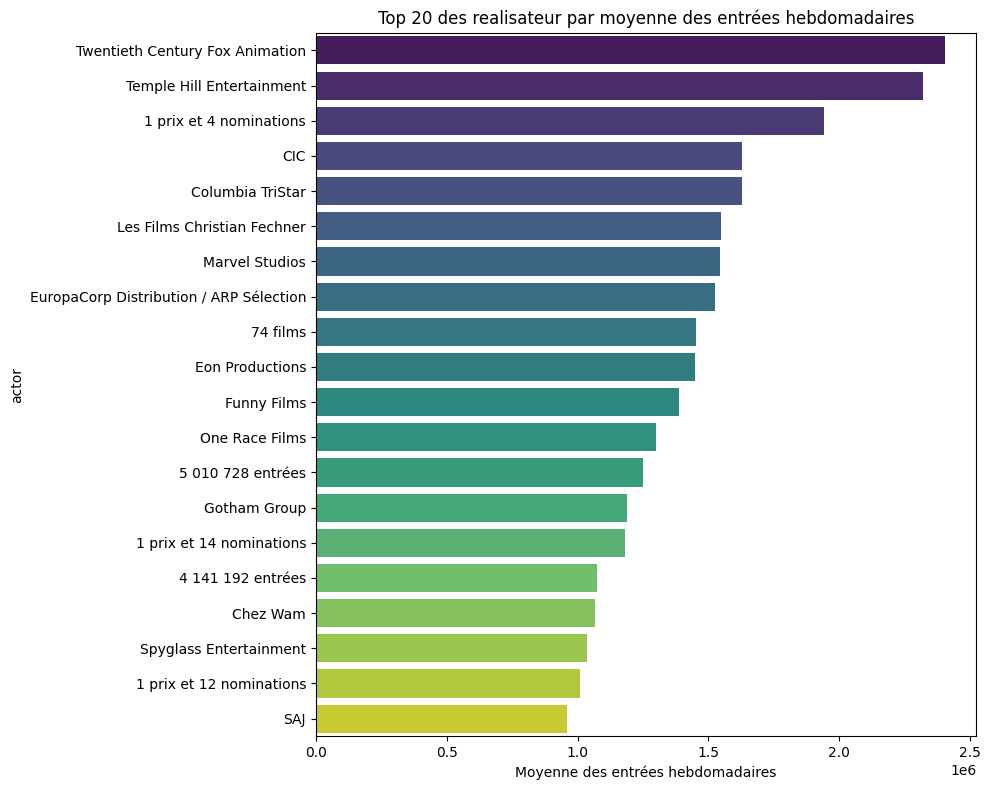

In [36]:
# On prend les 20 pays avec les meilleures moyennes
top_n = 20
df_top_actor = df.groupby('distribution')['weekly_entrances'].mean().sort_values(ascending=False)

df_top_actor = df_top_actor.head(top_n)


# Tracer un bar chart horizontal
plt.figure(figsize=(10, 8))
sns.barplot(x=df_top_actor.values, y=df_top_actor.index, palette="viridis")
plt.title(f'Top {top_n} des realisateur par moyenne des entrées hebdomadaires')
plt.xlabel('Moyenne des entrées hebdomadaires')
plt.ylabel('actor')
plt.tight_layout()
plt.show()